In [49]:
import gensim
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
import argparse
import pickle
from nltk.corpus import WordNetCorpusReader
from collections import Counter
import seaborn as sns
import os

In [14]:
wn2 = WordNetCorpusReader("../../WordNet-2.0/dict", "../../WordNet-2.0/dict")

In [5]:
def get_top_words(embed_list, words, n=100):
    top_indices = embed_list.argsort()[-n:][::-1]
    top_words = [words[i] for i in top_indices]
    return top_words

def evaluate_dimensions(embed_matrix, words):
    dimension_count = {}
    print("shape: " + str(np.shape(embed_matrix)))
    for d in range(0, np.shape(embed_matrix)[1]):
        col = embed_matrix[:,d]
        top_words = get_top_words(col, words)
        dimension_count[d] = top_words
    return dimension_count

In [7]:
def get_data():
    print("loading data from dictionary mapping...")

    # save filename
    domains = pickle.load( open("../data/processed/domain-mapping.p", "rb" ) )

    return domains

# https://stackoverflow.com/questions/13881425/get-wordnets-domain-name-for-the-specified-word
def get_offsets(words):
    offsets = {}
    for w in words:
        syn = wn2.synsets(w)
        if len(syn) != 0:
            offset = wn2.synsets(w)[0].offset()
        else:
            offset = "n/a"
        offsets[w] = offset
#     print(" # of offsets: " + str(len(offsets)))
    return offsets 

def get_categories(words, offsets, domains):
    categories = {}
    flatten_categories = set()
    for w in words:
        o = offsets[w]
        k = str(o).zfill(8)
        if k in domains:
            category = domains[k]
            if len(category) != 1:
                for c in category:
                    flatten_categories.add(c)
        else:
            category = "n/a"
        categories[w] = category
    return categories, flatten_categories

In [9]:
def get_all_values(d):
    if isinstance(d, dict):
        for v in d.values():
            yield from get_all_values(v)
    elif isinstance(d, list):
        for v in d:
            yield from get_all_values(v)
    else:
        yield d 

In [10]:
def get_domain_count(domains, dimension_dict, spine_embeddings, spine_tokens):
    dimension_to_category_map = {}
    for i in tqdm(range(len(dimension_dict.keys()))):
        caetgory_counter = {}
        data = dimension_dict[i]
        offsets = get_offsets(data)
        categories, _ = get_categories(data, offsets, domains) 
        vals = list(get_all_values(categories))
        dimension_to_category_map[i] = Counter(vals)
    return dimension_to_category_map

100%|██████████| 1000/1000 [00:11<00:00, 83.66it/s]


In [56]:
if not os.path.exists('../../images/'):
    os.makedirs('../../images/')

def convert_to_df(col, category_labels):
    missing_categories = set(category_labels).difference(set(col.keys()))
    missing_dict = {}
    for mc in missing_categories:
        missing_dict[mc] = 0
    col.update(missing_dict)
    df_col = pd.DataFrame(list(col.items()), columns=['domain', 'count'])
    return df_col

def plot_graphs(dimension_to_category_map, category_labels, embedding_type=""):
    num_dimensions = len(dimension_to_category_map)
    for i in tqdm(range(num_dimensions)):
        plt.clf()
        plt.rcParams["xtick.labelsize"] = 3
        col = dimension_to_category_map[i]
        df_col = convert_to_df(col, category_labels)
        graph = sns.barplot(x='domain', y="count", data=df_col, order=sorted(df_col['domain']))
        graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
        plt.title("dimension " + str(i))
        plt.tight_layout()
        plt.savefig("../../images/dimension-" + str(i) + "-" + embedding_type + ".png")
    return

## WordNet Domains

In [74]:
domains = get_data()
print(" # of words: " + str(len(domains.keys())))

all_categories = []
for c in domains.values():
    all_categories.extend(c)
print(" # of wordnet categories: " + str(len(list(set(all_categories)))))

category_labels = sorted(list(set(all_categories)))
category_labels[:10]

loading data from dictionary mapping...
 # of words: 115103
 # of wordnet categories: 168


['acoustics',
 'administration',
 'agriculture',
 'anatomy',
 'animal_husbandry',
 'animals',
 'anthropology',
 'applied_science',
 'archaeology',
 'archery']

## GLoVE

In [73]:
def get_embeddings(file):
    spine = open("../data/external/" + str(file),"r") .read().split('\n')
    spine.pop(15000) # remove the last empty object
    print(len(spine))

    spine_tokens = []
    spine_embeddings = []

    for i, line in enumerate(spine):
        tokens = line.strip().split()
        spine_tokens.append(tokens[0])
        spine_embeddings.append([float(i) for i in tokens[1:]])

    spine_tokens = np.array(spine_tokens)
    spine_embeddings = np.array(spine_embeddings)

    dimension_dict = evaluate_dimensions(spine_embeddings, spine_tokens)
    return dimension_dict, spine_tokens, spine_embeddings

In [ ]:
glove_dimension_dict, glove_spine_embeddings, glove_spine_tokens = get_embeddings("SPINE_glove.txt")
glove_dimension_to_category_map = get_domain_count(domains, glove_dimension_dict, glove_spine_embeddings, glove_spine_tokens)

### WordNet Domains


  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


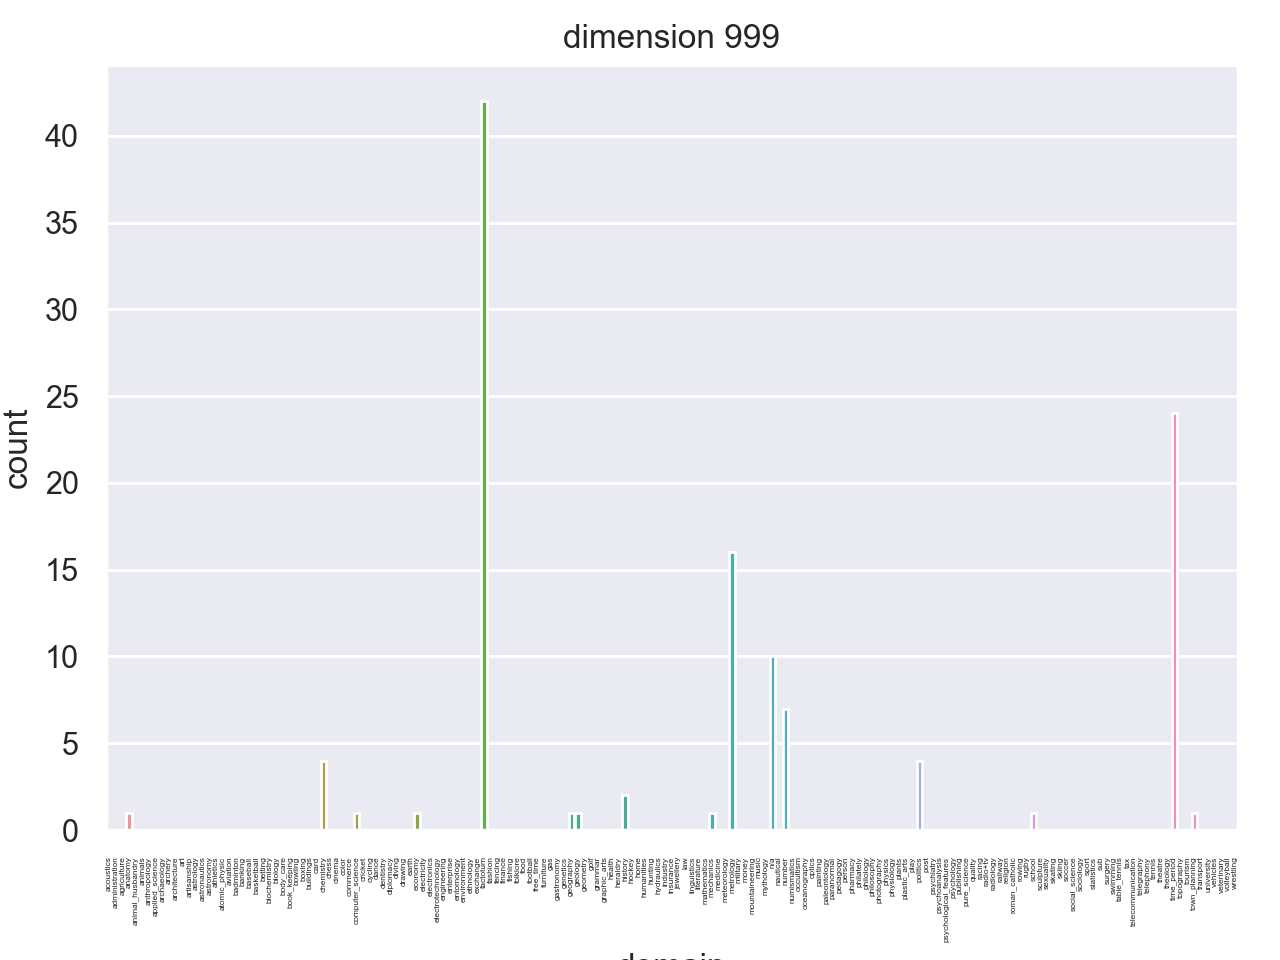


100%|██████████| 1000/1000 [39:18<00:00,  2.82s/it] 


In [57]:
plot_graphs(dimension_to_category_map, category_labels, "glove")

In [59]:
category_labels

['acoustics',
 'administration',
 'agriculture',
 'anatomy',
 'animal_husbandry',
 'animals',
 'anthropology',
 'applied_science',
 'archaeology',
 'archery',
 'architecture',
 'art',
 'artisanship',
 'astrology',
 'astronautics',
 'astronomy',
 'athletics',
 'atomic_physic',
 'aviation',
 'badminton',
 'banking',
 'baseball',
 'basketball',
 'betting',
 'biochemistry',
 'biology',
 'body_care',
 'book_keeping',
 'bowling',
 'boxing',
 'buildings',
 'card',
 'chemistry',
 'chess',
 'cinema',
 'color',
 'commerce',
 'computer_science',
 'cricket',
 'cycling',
 'dance',
 'dentistry',
 'diplomacy',
 'diving',
 'drawing',
 'earth',
 'economy',
 'electricity',
 'electronics',
 'electrotechnology',
 'engineering',
 'enterprise',
 'entomology',
 'environment',
 'ethnology',
 'exchange',
 'factotum',
 'fashion',
 'fencing',
 'finance',
 'fishing',
 'folklore',
 'food',
 'football',
 'free_time',
 'furniture',
 'gas',
 'gastronomy',
 'genetics',
 'geography',
 'geology',
 'geometry',
 'golf',
 

## word2vec

In [75]:
wv_dimension_dict, wv_spine_embeddings, wv_spine_tokens = get_embeddings("SPINE_word2vec.txt")
wv_dimension_to_category_map = get_domain_count(domains, wv_dimension_dict, wv_spine_embeddings, wv_spine_tokens)

15000
shape: (15000, 1000)


100%|██████████| 1000/1000 [00:10<00:00, 94.79it/s]


In [76]:
plot_graphs(wv_dimension_to_category_map, category_labels, "word2vec")

100%|██████████| 1000/1000 [49:07<00:00,  2.85s/it] 


## specific dimensions

In [77]:
def specific_dimension(i, dimension_to_category_map, category_labels):
    num_dimensions = len(dimension_to_category_map)
    col = dimension_to_category_map[i]
    df_col = convert_to_df(col, category_labels)
    return df_col

In [92]:
def find_top_domains(indices, word):
    print("WORD: " + str(word))
    for i in indices:
        print("INDEX: " + str(i))
        specific_col_wv = specific_dimension(i, wv_dimension_to_category_map, category_labels)
        specific_col_wv = specific_col_wv.sort_values(by='count', ascending=False)
#         print(" total domains: " + specific_col_wv['count'])
        print(specific_col_wv.head())
        print()
    return

In [93]:
find_top_domains([239, 184, 89], "internet")
find_top_domains([131, 289, 253], "mathematics")
find_top_domains([35, 178, 42], "remote")

WORD: internet
INDEX: 239
       domain  count
10   factotum     28
3    commerce     10
5     economy     10
2   chemistry      8
0         n/a      7

INDEX: 184
       domain  count
3    factotum     29
2   transport     12
6     anatomy     10
7   buildings      6
10   military      6

INDEX: 89
       domain  count
2   chemistry     20
0    factotum     19
5    medicine     18
3    pharmacy      9
13  geography      9

WORD: mathematics
INDEX: 131
        domain  count
1     factotum     56
2  meteorology      9
3     military      7
0      geology      6
5    sociology      4

INDEX: 289
       domain  count
19        n/a     14
2   geography     14
15   factotum     11
9   buildings     11
5    religion     10

INDEX: 253
       domain  count
0   geography     21
5    politics     10
13   factotum     10
4         n/a      8
6     history      6

WORD: remote
INDEX: 35
     domain  count
0    person     48
3  factotum     28
6  military      5
1     sport      5
8       law     